In [1]:
import datetime
import os

import matplotlib.pyplot as plt
import numpy as np
import pyeit.mesh as mesh
import tensorflow as tf
from PIL import Image
from sciopy import norm_data, plot_mesh
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from support import GREIT_sample, plot_reconstruction, show_mesh
from tensorflow import GradientTape, exp, keras, reduce_mean, reduce_sum, shape, square
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.losses import Huber, binary_crossentropy, mse
from tensorflow.keras.metrics import Mean
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tqdm import tqdm

2023-11-06 09:19:54.679357: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


![gif](../codes/r_traj.gif)

In [2]:
l_path = "../data/h0=0.05_n_el=16_r_obj=0.3_dist_exc=8_step_meas=4noise=TrueT=10/"

In [3]:
tmp = np.load(l_path + "sample_000000.npz", allow_pickle=True)
tmp.files

['anomaly',
 'perm_array',
 'n_el',
 'h0',
 'v_empty',
 'v_obj',
 'dist_exc',
 'step_meas']

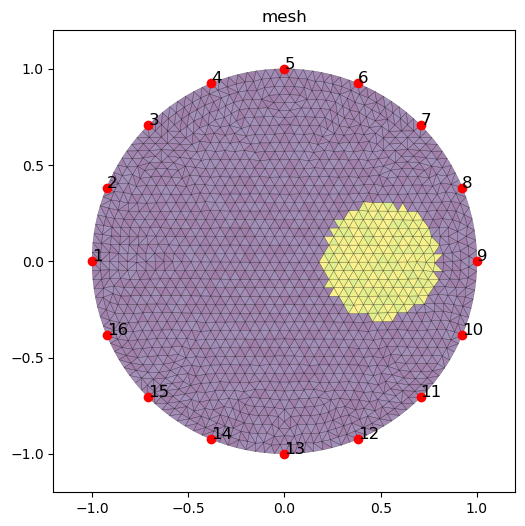

In [4]:
# create empty mesh:
mesh_obj = mesh.create(tmp["n_el"], h0=tmp["h0"])
mesh_obj.perm = tmp["perm_array"]
plot_mesh(mesh_obj)

In [5]:
V = list()
radii = list()
perms = list()

for ele in tqdm(np.sort(os.listdir(l_path))):
    tmp_l = np.load(l_path + ele, allow_pickle=True)
    V.append(tmp_l["v_obj"])
    radii.append(tmp_l["anomaly"].tolist().center)
    perms.append(tmp_l["perm_array"])

V = np.array(V)
perms = np.array(perms)  # / 25  # DIVIDED BY 15 FOR VAE RANGE
radii = np.array(radii)

100%|██████████| 10000/10000 [00:34<00:00, 289.26it/s]


In [6]:
tt_spl = 5000
V_train = V[:tt_spl]
V_test = V[tt_spl:]
perms_train = perms[:tt_spl]
np.random.shuffle(perms_train)
perms_test = perms[tt_spl:]
radii_train = radii[:tt_spl]
radii_test = radii[tt_spl:]

In [7]:
perms_train = perms[:tt_spl]

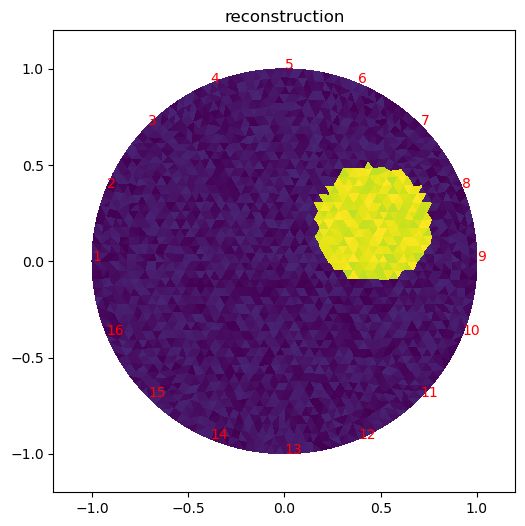

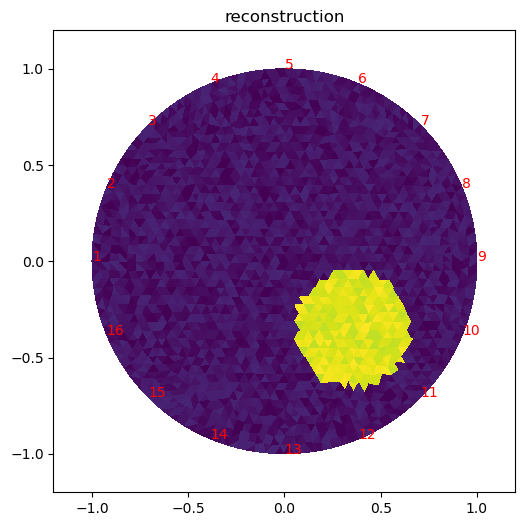

In [8]:
plot_reconstruction(mesh_obj, perms_train[0])
plot_reconstruction(mesh_obj, perms_train[1])

## Build VAE

In [9]:
import tensorflow as tf
from tensorflow import GradientTape, exp, keras, reduce_mean, reduce_sum, shape, square
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.losses import Huber, binary_crossentropy, mse
from tensorflow.keras.metrics import Mean
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam


class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


latent_dim = 8


def encoder_model_circle(inp_shape=(2821,), latent_dim=latent_dim):
    encoder_inputs = keras.Input(shape=inp_shape)
    x = layers.Reshape((2821, 1))(encoder_inputs)
    x = layers.ZeroPadding1D((379, 0))(x)
    x = layers.Conv1D(16, activation="relu", kernel_size=9, strides=1, padding="same")(
        x
    )
    x = layers.Conv1D(16, activation="relu", kernel_size=9, strides=1, padding="same")(
        x
    )
    x = layers.Conv1D(16, activation="relu", kernel_size=9, strides=4, padding="same")(
        x
    )
    x = layers.Conv1D(32, activation="relu", kernel_size=9, strides=1, padding="same")(
        x
    )
    x = layers.Conv1D(32, activation="relu", kernel_size=9, strides=4, padding="same")(
        x
    )
    x = layers.Conv1D(64, activation="relu", kernel_size=9, strides=1, padding="same")(
        x
    )
    x = layers.Conv1D(64, activation="relu", kernel_size=9, strides=5, padding="same")(
        x
    )
    x = layers.Flatten()(x)
    x = layers.Dense(
        1024,
        activation="relu",
        kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),
        bias_regularizer=regularizers.L2(1e-4),
        activity_regularizer=regularizers.L2(1e-5),
    )(x)
    x = layers.Dense(512, activation="relu")(x)
    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dense(16, activation="relu")(x)

    z_mean = layers.Dense(latent_dim, name="z_mean")(x)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
    z = Sampling(name="z")([z_mean, z_log_var])

    return encoder_inputs, z_mean, z_log_var, z


def decoder_model_circle(latent_dim=latent_dim):
    latent_inputs = keras.Input(shape=(latent_dim,), name="z_sampling")

    x = layers.Dense(16, activation="relu")(latent_inputs)
    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dense(512, activation="relu")(x)
    x = layers.Dense(1024, activation="relu")(x)
    x = layers.Dense(
        2560,
        activation="relu",
        kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),
        bias_regularizer=regularizers.L2(1e-4),
        activity_regularizer=regularizers.L2(1e-5),
    )(x)
    x = layers.Reshape((40, 64))(x)

    x = layers.Conv1DTranspose(
        64, activation="relu", kernel_size=9, strides=5, padding="same"
    )(x)
    x = layers.Conv1DTranspose(
        32, activation="relu", kernel_size=9, strides=1, padding="same"
    )(x)
    x = layers.Conv1DTranspose(
        32, activation="relu", kernel_size=9, strides=4, padding="same"
    )(x)
    x = layers.Conv1DTranspose(
        16, activation="relu", kernel_size=9, strides=1, padding="same"
    )(x)
    x = layers.Conv1DTranspose(
        16, activation="relu", kernel_size=9, strides=4, padding="same"
    )(x)
    x = layers.Conv1DTranspose(
        1, activation="relu", kernel_size=9, strides=1, padding="same"
    )(x)

    x = layers.Cropping1D(cropping=(379, 0))(x)
    decoder_outputs = layers.Flatten()(x)

    return latent_inputs, decoder_outputs


class VAE(Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)

            reconstruction_loss = tf.reduce_mean(
                tf.keras.losses.mean_absolute_error(data, reconstruction)
            )

            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstruction = self.decoder(z)
        reconstruction_loss = tf.reduce_mean(tf.losses.mean_absolute_error(inputs, reconstruction))
        reconstruction_loss *= 2821
        kl_loss = 1 + z_log_var - square(z_mean) - exp(z_log_var)
        kl_loss = reduce_mean(kl_loss)
        kl_loss *= -0.5
        total_loss = reconstruction_loss + kl_loss
        self.add_metric(kl_loss, name="kl_loss", aggregation="mean")
        self.add_metric(total_loss, name="total_loss", aggregation="mean")
        self.add_metric(
            reconstruction_loss, name="reconstruction_loss", aggregation="mean"
        )
        return reconstruction


def vae_circle():
    encoder_inputs, z_mean, z_log_var, z = encoder_model_circle()
    encoder = Model(encoder_inputs, (z_mean, z_log_var, z), name="VAE_encoder")
    encoder.summary()

    decoder_inputs, decoder_outputs = decoder_model_circle()
    decoder = Model(decoder_inputs, decoder_outputs, name="VAE_decoder")
    decoder.summary()

    return VAE(encoder, decoder)


vae = vae_circle()

2023-11-06 09:20:42.517073: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46672 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:01:00.0, compute capability: 8.6
2023-11-06 09:20:42.519232: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 46672 MB memory:  -> device: 1, name: NVIDIA RTX A6000, pci bus id: 0000:81:00.0, compute capability: 8.6


Model: "VAE_encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 2821)]       0           []                               
                                                                                                  
 reshape (Reshape)              (None, 2821, 1)      0           ['input_1[0][0]']                
                                                                                                  
 zero_padding1d (ZeroPadding1D)  (None, 3200, 1)     0           ['reshape[0][0]']                
                                                                                                  
 conv1d (Conv1D)                (None, 3200, 16)     160         ['zero_padding1d[0][0]']         
                                                                                        

In [10]:
vae.compile(Adam(), loss=tf.losses.mean_absolute_error)
history = vae.fit(perms_train, epochs=20, batch_size=32)

Epoch 1/20


2023-11-06 09:20:47.218062: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-11-06 09:20:48.068028: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-11-06 09:20:48.370667: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x55d20a77e510 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-06 09:20:48.370758: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2023-11-06 09:20:48.370781: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (1): NVIDIA RTX A6000, Compute Capability 8.6
2023-11-06 09:20:48.407018: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-06 09:20:48.64757

157/157 [==============================] - 12s 17ms/step - loss: 1.3689 - reconstruction_loss: 1.1365 - kl_loss: 0.0012
Epoch 2/20
157/157 [==============================] - 2s 15ms/step - loss: 1.0200 - reconstruction_loss: 1.0196 - kl_loss: 1.8014e-07
Epoch 3/20
157/157 [==============================] - 2s 15ms/step - loss: 1.0192 - reconstruction_loss: 1.0191 - kl_loss: 5.5998e-08
Epoch 4/20
157/157 [==============================] - 2s 15ms/step - loss: 1.0188 - reconstruction_loss: 1.0187 - kl_loss: 4.7266e-08
Epoch 5/20
157/157 [==============================] - 2s 12ms/step - loss: 1.0185 - reconstruction_loss: 1.0185 - kl_loss: 4.1192e-08
Epoch 6/20
157/157 [==============================] - 2s 12ms/step - loss: 1.0185 - reconstruction_loss: 1.0184 - kl_loss: 3.4358e-08
Epoch 7/20
157/157 [==============================] - 2s 11ms/step - loss: 1.0182 - reconstruction_loss: 1.0183 - kl_loss: 3.9863e-08
Epoch 8/20
157/157 [==============================] - 2s 11ms/step - loss: 1

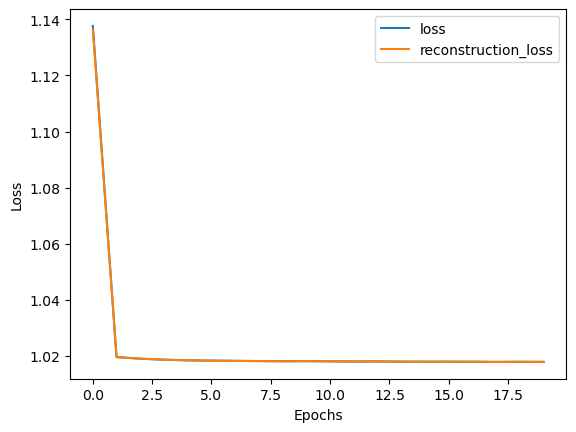

In [11]:
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["reconstruction_loss"], label="reconstruction_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [12]:
perms = list()

for ele in tqdm(np.sort(os.listdir(l_path))):
    tmp_l = np.load(l_path + ele, allow_pickle=True)
    perms.append(tmp_l["perm_array"])

perms = np.array(perms)  # / 25  # DIVIDED BY 15 FOR VAE RANGE

100%|██████████| 10000/10000 [00:18<00:00, 527.56it/s]


1/1 [==============================] - 0s 25ms/step


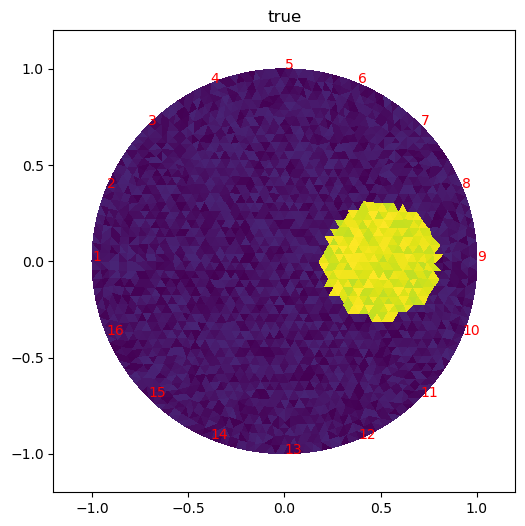

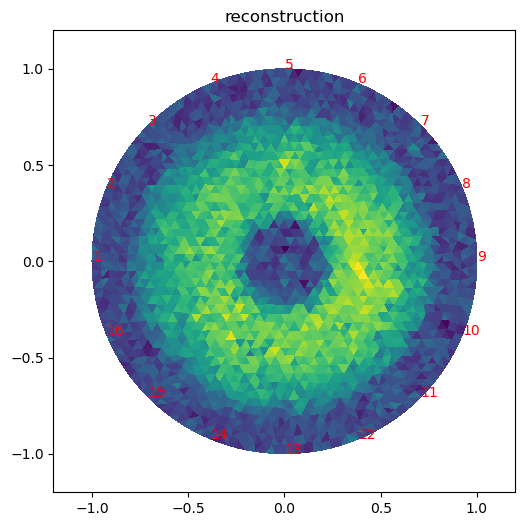

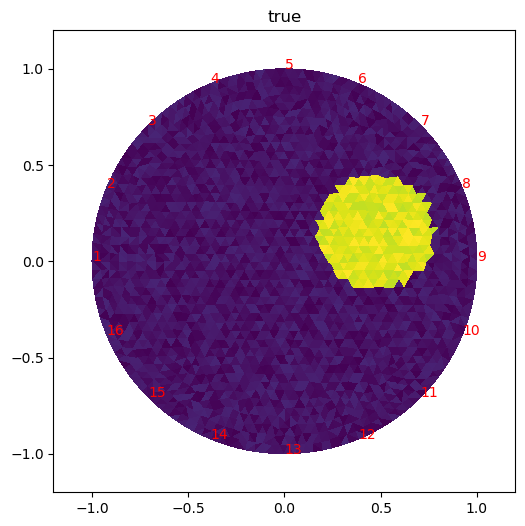

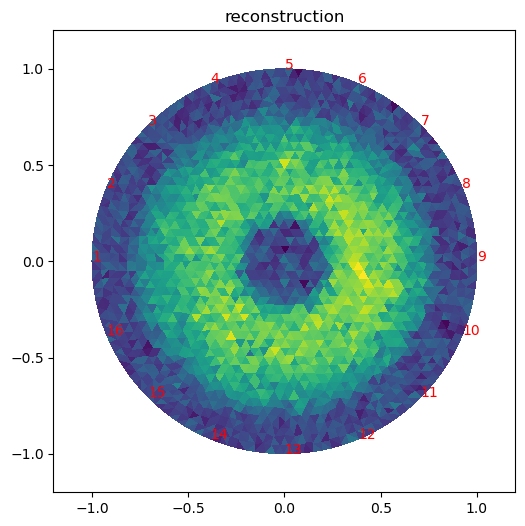

In [13]:
# reset order to default
perms_train = perms[:tt_spl]
_, _, z0 = vae.encoder.predict(np.expand_dims(perms_train[0, :], 0))
_, _, z50 = vae.encoder.predict(np.expand_dims(perms_train[50, :], 0))

plot_reconstruction(mesh_obj, perms_train[0, :], title="true")
plot_reconstruction(mesh_obj, np.concatenate(vae.decoder.predict(z0)))
plot_reconstruction(mesh_obj, perms_train[50, :], title="true")
plot_reconstruction(mesh_obj, np.concatenate(vae.decoder.predict(z50)))

In [14]:
train_z_mean, train_z_log_var, train_z = vae.encoder.predict(perms_train)
test_z_mean, test_z_log_var, test_z = vae.encoder.predict(perms_test)
all_z_mean, all_z_log_var, all_z = vae.encoder.predict(perms)

313/313 [==============================] - 1s 3ms/step


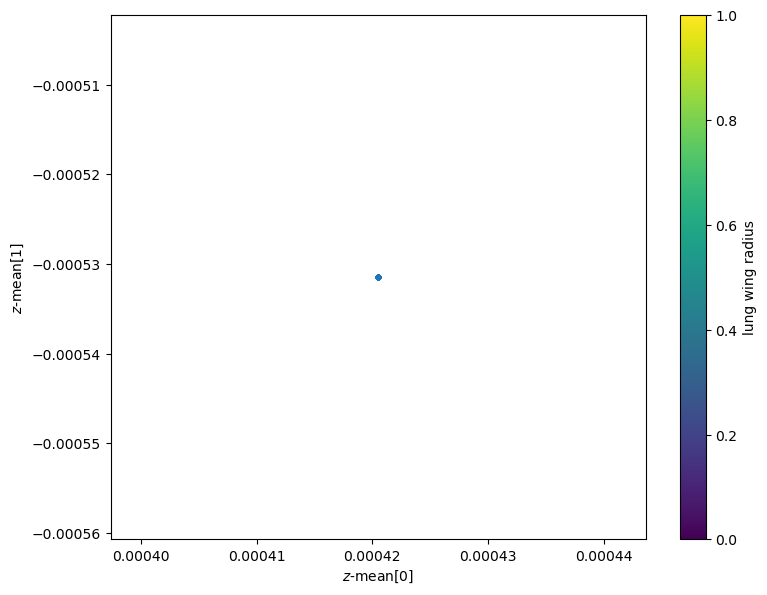

In [21]:
plt.figure(figsize=(8, 6))
plt.scatter(train_z_mean[:, 0], train_z_mean[:, 1], s=10)  # c=radii_train,
plt.xlabel("$z$-mean[0]")
plt.ylabel("$z$-mean[1]")
# plt.axis('off')
plt.tight_layout()
# plt.savefig("../../beauty_of_latent_spaces/1.pdf")
plt.colorbar(label="lung wing radius")
plt.show()

In [ ]:
# Perform t-SNE to reduce the dimensionality to 2D
tsne = TSNE(n_components=2)
# latent_space_2d = tsne.fit_transform(train_z_mean)  # latent data
latent_space_2d = tsne.fit_transform(all_z)  # latent data

In [ ]:
plt.figure(figsize=(6, 6))
plt.scatter(latent_space_2d[:, 0], latent_space_2d[:, 1], c=radii, s=10)
plt.xlabel("tsne latent dimention 1")
plt.ylabel("tsne latent dimention 2")
# plt.colorbar(label="lung wing radius")
# plt.grid()
plt.tight_layout()
# plt.savefig("../../beauty_of_latent_spaces/5.pdf")
plt.show()

## Mapper with LSTM

In [144]:
nseg = 3

X = [V_train[n : n + nseg, :] for n in range(V_train.shape[0] - nseg + 1)]
X = np.array(X)

Y_v = np.array(V_train[nseg - 1 :])

Y_perms = perms_train[nseg - 1 :]
_, _, Y = vae.encoder.predict(Y_perms)

250/250 [==============================] - 1s 3ms/step


In [145]:
print(X.shape, Y.shape)

(7998, 3, 192) (7998, 8)


In [146]:
np.allclose(X[0, nseg - 1, :], Y_v[0, :])

True

In [165]:
def mapper_model_lstm(input_shape_lstm, nseg, input_shape_mapper, v_shape, latent_dim):
    def Slice(s):
        def func(x):
            return x[:, s, :]

        return func

    inputs = layers.Input(shape=input_shape_lstm)

    # define shared layers
    dense = layers.Dense(v_shape, activation="relu")
    dropout = layers.Dropout(0.5)
    batch_normalization = layers.BatchNormalization()

    con_list = []
    for s in range(nseg):
        x = layers.Lambda(Slice(s))(inputs)
        x = dense(x)
        x = dropout(x)
        con_list.append(x)

    # concat and reshape for LSTM
    x = layers.Concatenate(axis=1)(con_list)
    x = layers.Reshape((nseg, int(x.shape[1] / nseg)))(x)
    x = layers.LSTM(v_shape)(x)

    # x = dropout(x)

    mapper_inputs = layers.Activation("softmax")(x)
    x = layers.Dense(128, activation="relu")(mapper_inputs)
    # x = layers.BatchNormalization()(x)
    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dense(32, activation="relu")(x)
    x = layers.Dense(16, activation="relu")(x)
    x = layers.Dense(latent_dim, activation="relu")(x)

    return Model(inputs, x)


mapper_lstm = mapper_model_lstm(
    input_shape_lstm=(nseg, 192),
    nseg=nseg,
    input_shape_mapper=(192,),
    v_shape=192,
    latent_dim=latent_dim,
)
mapper_lstm.compile(optimizer=Adam(), loss=tf.losses.mean_squared_error)
mapper_lstm.summary()

Model: "model_15"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_19 (InputLayer)          [(None, 3, 192)]     0           []                               
                                                                                                  
 lambda_48 (Lambda)             (None, 192)          0           ['input_19[0][0]']               
                                                                                                  
 lambda_49 (Lambda)             (None, 192)          0           ['input_19[0][0]']               
                                                                                                  
 lambda_50 (Lambda)             (None, 192)          0           ['input_19[0][0]']               
                                                                                           

2023-11-06 07:50:00.224983: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-06 07:50:00.226226: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-06 07:50:00.227139: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [166]:
history_lstm = mapper_lstm.fit(
    X,
    Y,
    epochs=25,
    batch_size=64,
)

Epoch 1/25


2023-11-06 07:50:04.316469: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-06 07:50:04.317809: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-06 07:50:04.318839: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

125/125 [==============================] - 3s 7ms/step - loss: 1.0311
Epoch 2/25
125/125 [==============================] - 1s 7ms/step - loss: 1.0310
Epoch 3/25
125/125 [==============================] - 1s 7ms/step - loss: 1.0310
Epoch 4/25
125/125 [==============================] - 1s 7ms/step - loss: 1.0310
Epoch 5/25
125/125 [==============================] - 1s 7ms/step - loss: 1.0310
Epoch 6/25
125/125 [==============================] - 1s 7ms/step - loss: 1.0310
Epoch 7/25
125/125 [==============================] - 1s 7ms/step - loss: 1.0310
Epoch 8/25
125/125 [==============================] - 1s 7ms/step - loss: 1.0310
Epoch 9/25
125/125 [==============================] - 1s 7ms/step - loss: 1.0310
Epoch 10/25
125/125 [==============================] - 1s 7ms/step - loss: 1.0310
Epoch 11/25
125/125 [==============================] - 1s 7ms/step - loss: 1.0310
Epoch 12/25
125/125 [==============================] - 1s 7ms/step - loss: 1.0310
Epoch 13/25
125/125 [===============

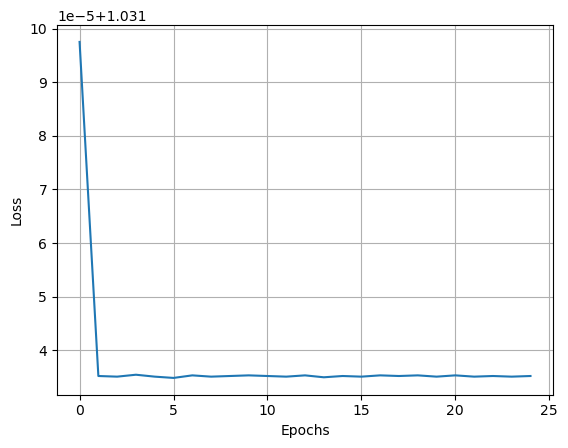

In [167]:
plt.plot(history_lstm.history["loss"])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid()
plt.show()

In [151]:
pred_lstm = mapper.predict(X)

 21/250 [=>............................] - ETA: 0s  

2023-11-06 07:44:33.746881: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-06 07:44:33.748240: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-06 07:44:33.749231: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

250/250 [==============================] - 1s 3ms/step


In [152]:
Perm_pred_lstm = vae.decoder.predict(pred_lstm)

250/250 [==============================] - 1s 3ms/step


In [153]:
Perm_pred_lstm.shape

(7998, 1912)

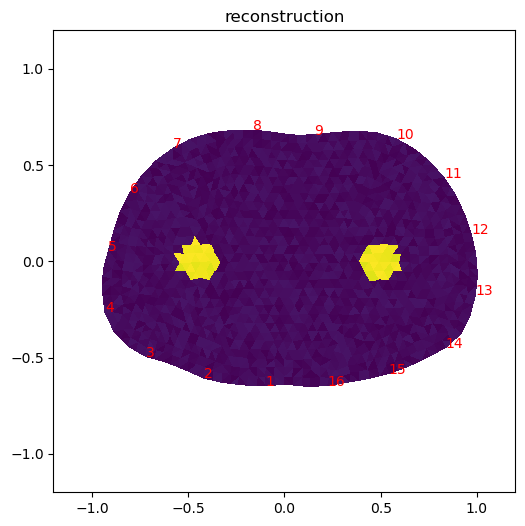

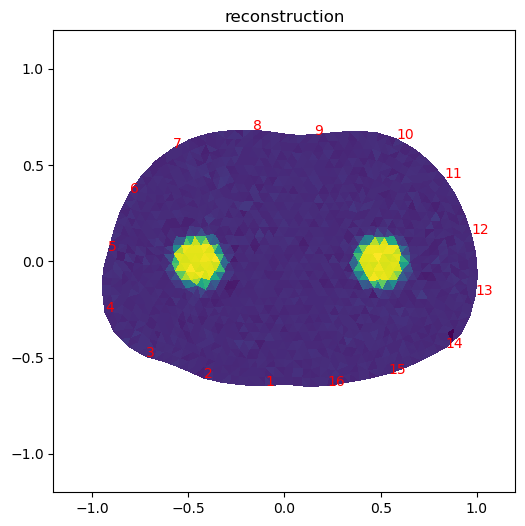

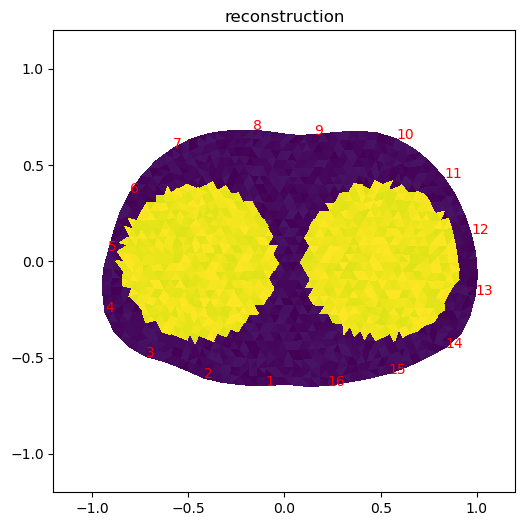

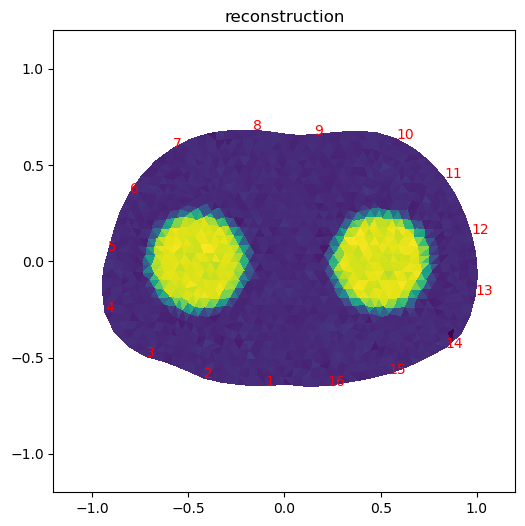

In [154]:
plot_reconstruction(mesh_obj, perms_train[0, :])
plot_reconstruction(mesh_obj, Perm_pred_lstm[0, :])
plot_reconstruction(mesh_obj, perms_train[50, :])
plot_reconstruction(mesh_obj, Perm_pred_lstm[50, :])

In [ ]:
nseg = 1

X = [V_train[n : n + nseg, :] for n in range(V_train.shape[0] - nseg + 1)]
X = np.array(X)

Y_v = np.array(V_train[nseg - 1 :])

Y_perms = perms_train[nseg - 1 :]
_, _, Y = vae.encoder.predict(Y_perms)

In [179]:
def mapper_model(input_shape=(192,), latent_dim=8):

    mapper_inputs = layers.Input(shape=input_shape)
    x = layers.Dense(128, activation="relu")(mapper_inputs)
    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dense(32, activation="relu")(x)
    x = layers.Dense(16, activation="relu")(x)
    x = layers.Dense(latent_dim, activation="relu")(x)

    return Model(mapper_inputs, x)


mapper_ = mapper_model()
mapper_.compile(Adam(), loss=tf.losses.mean_squared_error)
mapper_.summary()

250/250 [==============================] - 1s 3ms/step
Model: "model_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_23 (InputLayer)       [(None, 192)]             0         
                                                                 
 dense_112 (Dense)           (None, 128)               24704     
                                                                 
 dense_113 (Dense)           (None, 64)                8256      
                                                                 
 dense_114 (Dense)           (None, 32)                2080      
                                                                 
 dense_115 (Dense)           (None, 16)                528       
                                                                 
 dense_116 (Dense)           (None, 8)                 136       
                                                                 
Tot

In [180]:
Y.shape

(8000, 8)

In [181]:
history_ = mapper_.fit(
    X[:, 0, :],
    Y,
    epochs=25,
    batch_size=64,
)

Epoch 1/25
125/125 [==============================] - 2s 3ms/step - loss: 0.9678
Epoch 2/25
125/125 [==============================] - 0s 4ms/step - loss: 0.9500
Epoch 3/25
125/125 [==============================] - 0s 4ms/step - loss: 0.9499
Epoch 4/25
125/125 [==============================] - 0s 4ms/step - loss: 0.9505
Epoch 5/25
125/125 [==============================] - 0s 3ms/step - loss: 0.9502
Epoch 6/25
125/125 [==============================] - 0s 3ms/step - loss: 0.9507
Epoch 7/25
125/125 [==============================] - 0s 4ms/step - loss: 0.9499
Epoch 8/25
125/125 [==============================] - 0s 4ms/step - loss: 0.9496
Epoch 9/25
125/125 [==============================] - 0s 3ms/step - loss: 0.9498
Epoch 10/25
125/125 [==============================] - 0s 4ms/step - loss: 0.9500
Epoch 11/25
125/125 [==============================] - 0s 4ms/step - loss: 0.9503
Epoch 12/25
125/125 [==============================] - 0s 4ms/step - loss: 0.9498
Epoch 13/25
125/125 [====

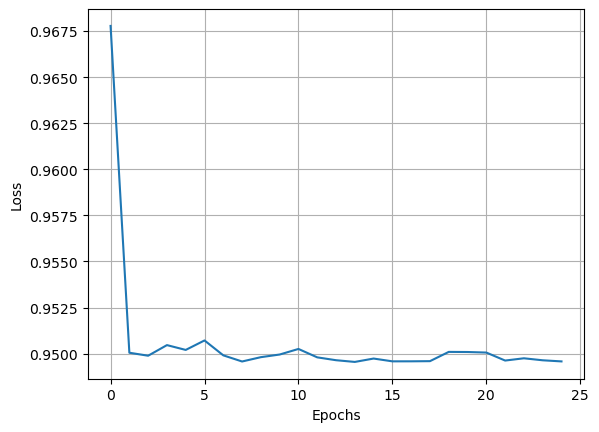

In [182]:
plt.plot(history_.history["loss"])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid()
plt.show()

In [183]:
pred_ = mapper.predict(X[:, 0, :])

250/250 [==============================] - 0s 644us/step


In [184]:
Perm_pred_ = vae.decoder.predict(pred_)

250/250 [==============================] - 1s 3ms/step


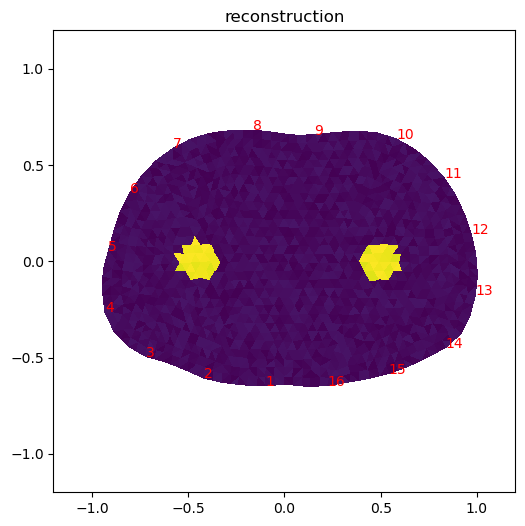

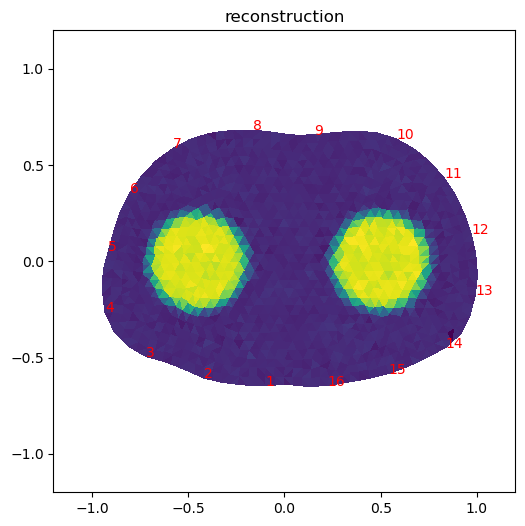

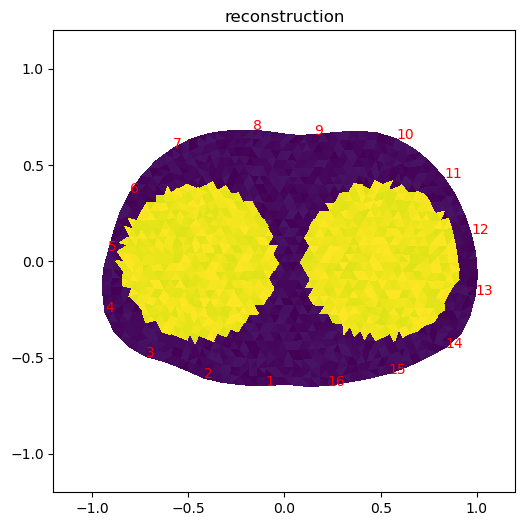

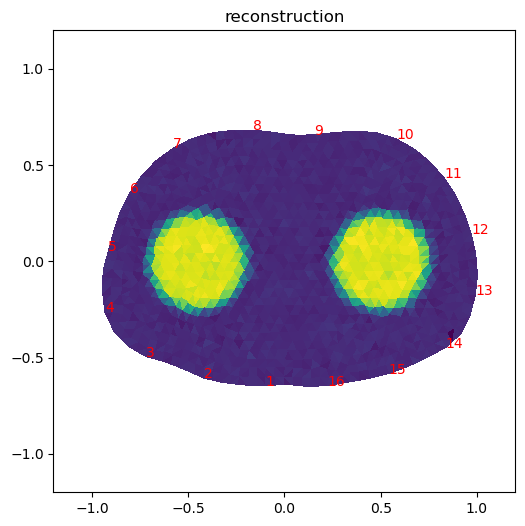

In [185]:
plot_reconstruction(mesh_obj, perms_train[0, :])
plot_reconstruction(mesh_obj, Perm_pred_[0, :])
plot_reconstruction(mesh_obj, perms_train[50, :])
plot_reconstruction(mesh_obj, Perm_pred_[50, :])

In [155]:
def perm_deviation(perm_true, perm_rec, brdr=5):
    dev = len(np.argwhere(perm_true > brdr)) - len(np.argwhere(perm_rec > brdr))
    return dev

In [156]:
perm_deviation(perms_train[0, :], Perm_pred[0, :])

-34

In [157]:
err = list()
for i in tqdm(range(Perm_pred.shape[0])):
    err.append(perm_deviation(perms_train[i, :], Perm_pred[i, :]))

100%|██████████| 7998/7998 [00:00<00:00, 41305.28it/s]


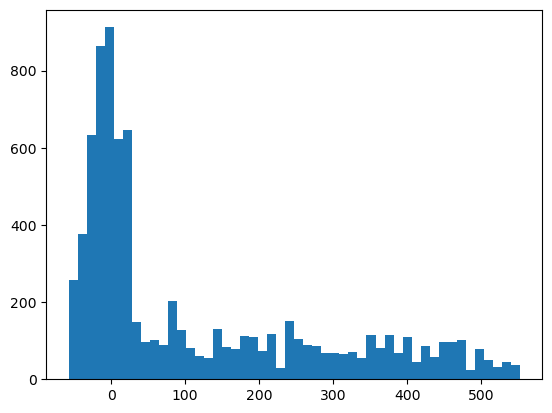

In [164]:
plt.hist(err, bins=50)
plt.show()